# 円柱の軸出し精度のpcaとfittingの比較

## test_cylinder_fitting.pyの中身

In [1]:
# from test_cylinder_fitting import *
import random
random.seed(0)
from geo import *
from face_fit import *

import numpy
import numpy.linalg


In [2]:
def distort(pos,sigma) :
    return map(lambda x: x+random.normalvariate(0,sigma), pos)

def make_cylinder_point_cloud(n,r,l_range,angle_range,sigma=None,transform=None) :
    rslt = []
    for i in range(n) :
        zz=random.uniform(l_range[0],l_range[1])
        th=random.uniform(angle_range[0],angle_range[1])
        if sigma :
            tmp=VECTOR(vec=list(distort([r*cos(th),r*sin(th),zz],sigma)))
        else :
            tmp=VECTOR(r*cos(th),r*sin(th),zz)
        if transform :
            tmp=transform*tmp
        rslt.append(tmp)
    return rslt

In [3]:
def calc_pca(point_cloud) :
    tmp=numpy.array(point_cloud).T
    tmp=numpy.cov(tmp,bias=True)
    return numpy.linalg.eig(tmp)

In [4]:
def calc_axis_center_pca(point_cloud) :
    tmp=calc_pca(point_cloud)
    idx=numpy.argmax(tmp[0])
    cc=numpy.average(point_cloud,axis=0)
    return VECTOR(tmp[1][0][idx], tmp[1][1][idx], tmp[1][2][idx]),VECTOR(cc[0],cc[1],cc[2])

In [5]:
def make_cylinder_face_data(point_cloud,radius,transform=None) :
    if not transform :
        transform=FRAME()
    return [["cylinder",transform,radius],point_cloud]

In [6]:
def outlier(p_list, sigma, n=1) :
    rslt=[]
    for pp in p_list :
        for i in range(n) :
            rslt.append( VECTOR(pp[0]+random.normalvariate(0,sigma),
                                pp[1]+random.normalvariate(0,sigma),
                                pp[2]+random.normalvariate(0,sigma)))
    return rslt

In [7]:
def cmp_with_tv(tv, axis, center) :
    tv_axis=tv.mat.col(2)
    tmp1=abs(axis*tv_axis)
    tmp2=(-tv)*center
    return tmp1, tmp2

## 関数の単体テスト

### 円柱表面上のpoint_cloudの生成

In [8]:
a=make_cylinder_point_cloud(100,10,[-100,100],[-pi,pi])

### 共分散行列を生成してpcaを行う．

In [9]:
aa=numpy.array(a).T

In [10]:
b=numpy.cov(aa,bias=True)

In [11]:
c=numpy.linalg.eig(b)
c

(array([3213.27768195,   52.2790474 ,   46.53225288]),
 array([[-0.00378424,  0.9671312 , -0.25424973],
        [ 0.00996903, -0.25420243, -0.96709966],
        [ 0.99994315,  0.00619436,  0.0086794 ]]))

第１主成分の軸を取り出す．

In [12]:
tmp=numpy.argmax(c[0])
VECTOR(c[1][0][tmp],c[1][1][tmp],c[1][2][tmp])

v:[-0.003784241077756072, 0.009969031333209265, 0.9999431473507596]

### pcaを求める部分をまとめた関数のテスト

In [13]:
calc_pca(a)

(array([3213.27768195,   52.2790474 ,   46.53225288]),
 array([[-0.00378424,  0.9671312 , -0.25424973],
        [ 0.00996903, -0.25420243, -0.96709966],
        [ 0.99994315,  0.00619436,  0.0086794 ]]))

重心を求める

In [14]:
numpy.average(a,axis=0)

array([ 0.72877932, -0.54565138,  7.18142443])

### pca を使って軸と重心（軸の通過位置）を求める

In [15]:
tmp=calc_axis_center_pca(a)
tmp

(v:[-0.003784241077756072, 0.009969031333209265, 0.9999431473507596],
 v:[0.7287793178926456, -0.5456513832318244, 7.181424433499858])

In [16]:
cmp_with_tv(FRAME(),tmp[0],tmp[1])

(0.010663117098535707,
 v:[0.7287793178926456, -0.5456513832318244, 7.181424433499858])

### face_fit.py用のデータ

In [17]:
f=make_cylinder_face_data(a,10)
f

[['cylinder',
  f:(m:[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]],v:[0.0, 0.0, 0.0]),
  10],
 [v:[-0.49958183201467393, 9.987513103526865, 68.88437030500961],
  v:[0.5599628954437964, -9.98430976861827, -15.885683833830996],
  v:[8.268478984060739, -5.624255976584449, 2.254944273721705],
  v:[3.2874436688709583, -9.44418943710895, 56.75971780695451],
  v:[8.65872348439298, 5.002650059800457, -4.680609169528836],
  v:[9.995664276858658, 0.2944412748438794, 81.62257703906704],
  v:[-0.36460807002559614, 9.99335083719531, -43.63243112005924],
  v:[0.03181431242067512, -9.999949392348203, 23.67379933506632],
  v:[-9.941561866942632, 1.0795126890185804, 81.94925119364802],
  v:[-8.169410403740258, 5.7672119481826245, 62.04344719931791],
  v:[1.2638198419622642, 9.919816500674923, -37.970486136133474],
  v:[4.029988352674712, 9.15200491025361, 79.7676575935987],
  v:[-8.064194745925654, -5.913439193885828, -5.571456909457325],
  v:[7.6694891999539045, 6.41708153382754, -13.16563290924

### 外れ値生成用の関数のテスト

In [18]:
outlier([VECTOR(1,0,0),VECTOR(0,1,0)],1,6)

[v:[0.8734432458871026, -1.2430457051469561, -0.04980953110323319],
 v:[0.9864907466924226, -0.2974394211491618, 0.2491099349434455],
 v:[0.4760689588007443, -0.40097026649446166, 1.1738576792081525],
 v:[3.0267252195784047, -0.19291317951565695, -0.7065251276395103],
 v:[-0.3125276022543755, 0.39616207451501667, 0.8840790108339466],
 v:[1.7030658173795512, 1.4309783107514624, 0.926593721570572],
 v:[1.9198097871157425, 0.5264434923857274, -1.213931979243707],
 v:[-1.3584790755077172, 1.5664453481982865, 0.21567282882685382],
 v:[-0.5965976245359932, 1.1177143806219447, -0.04949489717599043],
 v:[0.042559178734451246, 0.752611851569589, -0.16244448470877107],
 v:[1.332831905209186, 0.485096771873879, 0.5970921641251684],
 v:[-1.2812138556969408, 1.3482055149702687, 0.4565809236978218]]

### ガウス・ニュートン法の1回目

In [19]:
g=fit_face1(FRAME(xyzabc=[5,5,5,pi/6,pi/6,pi/6]),[f])
g

(f:(m:[[0.7513591464411092, -0.6559914677357819, 0.07165631386795007], [0.6510394389103459, 0.7546229311866306, 0.08180391623021199], [-0.10773616868345343, -0.014813034299298256, 0.9940691585459527]],v:[3.61121123518089, 3.2409578381546043, 4.910275710888731]),
 [-2.1729074363399317,
  -0.5563158110216354,
  -1.462560971049779e-15,
  -0.7286550688841125,
  -0.017384082812397485,
  3.903351958143094e-16])

### ２回目以降は以下を繰り返せば良い．

In [20]:
g=fit_face1(g[0],[f])
g

(f:(m:[[0.7541735528239153, -0.6563321671183001, 0.02122118344363754], [0.6551175590212064, 0.7542162063872316, 0.0444848051018374], [-0.04520216900823199, -0.01964689361319511, 0.9987846431980736]],v:[0.7291406506927856, 2.225258714871235, 5.201610290478198]),
 [-2.85811755307812,
  1.119828314100657,
  8.334222147277742e-16,
  -0.004862894570060115,
  -0.06274029109472604,
  -5.686591507849017e-16])

### 上記結果から軸と原点をだす．

In [21]:
print(g[0].mat.col(2))
print(g[0].vec)

v:[0.02122118344363754, 0.0444848051018374, 0.9987846431980736]
v:[0.7291406506927856, 2.225258714871235, 5.201610290478198]


In [22]:
cmp_with_tv(FRAME(),g[0].mat.col(2),g[0].vec)

(0.04928728549734683,
 v:[0.7291406506927856, 2.225258714871235, 5.201610290478198])

## 比較
### 比較のための準備

In [23]:
x=numpy.array([100,200,500,1000,2000,5000,10000,20000,50000,100000])
n_x=len(x)
pca_acc=numpy.zeros(n_x,dtype=numpy.float64)
fit_acc=numpy.zeros(n_x,dtype=numpy.float64)
pca_center=numpy.zeros(n_x,dtype=numpy.float64)
fit_center=numpy.zeros(n_x,dtype=numpy.float64)

In [24]:
import time
pca_tm=numpy.zeros(n_x,dtype=numpy.float64)
fit_tm=numpy.zeros(n_x,dtype=numpy.float64)

In [25]:
import matplotlib.pyplot as plt

def plot_data(pca,fit,y="y", log=False) :
    plt.plot(x,pca)
    plt.plot(x,fit)
    plt.xlabel("n")
    plt.ylabel(y)
    plt.xscale('log')

    if log :
        plt.yscale('log')

    plt.legend(["pca","fit"])
    plt.show()

### 点群生成パラメタ

In [26]:
tv=FRAME(xyzabc=[50,50,50,pi/3,pi/3,pi/3])
tv_z=tv.mat.col(2)
t_offset=FRAME(xyzabc=[5,5,5,pi/6,pi/6,pi/6])  # for gauss-newton

In [27]:
def do_pca_fit() :
    s_tm=time.time()    
    tmp1=calc_axis_center_pca(cpc)
    tmp2=cmp_with_tv(tv,tmp1[0],tmp1[1])
    pca_acc[i]=tmp2[0]
    ce=tmp2[1]
    ce[2]=0
    pca_center[i]=abs(ce)
    e_tm=time.time()
    pca_tm[i]=e_tm-s_tm
    
    print("time=", pca_tm[i])
    print(pca_acc[i])
    
    fit_data=make_cylinder_face_data(cpc,r)
    fit_init=tv*t_offset
    
    s_tm=time.time()
    fit=fit_face1(fit_init,[fit_data])
    tmp3=cmp_with_tv(tv,fit[0].mat.col(2),fit[0].vec)
    print("fit 0",tmp3[0])
    for j in range(5) :
        fit=fit_face1(fit[0],[fit_data])
        tmp3=cmp_with_tv(tv,fit[0].mat.col(2),fit[0].vec)
        print("fit",j+1,tmp3[0])
    tmp3=cmp_with_tv(tv,fit[0].mat.col(2),fit[0].vec)
    fit_acc[i]=tmp3[0]
    ce=tmp3[1]
    ce[2]=0
    fit_center[i]=abs(ce)                   
    e_tm=time.time()
    fit_tm[i]=e_tm-s_tm   
    print("time=",fit_tm[i])

### 直径の10倍の長さの円柱，誤差なし

In [28]:
r=10
l_range=[-100,100]
angle_range=[-pi,pi]

for i in range(n_x) :
    cpc=make_cylinder_point_cloud(x[i],r,l_range,angle_range,transform=tv)
    print(len(cpc))

    do_pca_fit()
    '''
    s_tm=time.time()    
    tmp1=calc_axis_center_pca(cpc)
    tmp2=cmp_with_tv(tv,tmp1[0],tmp1[1])
    pca_acc[i]=tmp2[0]
    ce=tmp2[1]
    ce[2]=0
    pca_center[i]=abs(ce)
    e_tm=time.time()
    pca_tm[i]=e_tm-s_tm
    
    print("time=", pca_tm[i])
    print(pca_acc[i])
    
    fit_data=make_cylinder_face_data(cpc,r)
    fit_init=tv*t_offset
    
    s_tm=time.time()
    fit=fit_face1(fit_init,[fit_data])
    tmp3=cmp_with_tv(tv,fit[0].mat.col(2),fit[0].vec)
    print("fit 0",tmp3[0])
    for j in range(5) :
        fit=fit_face1(fit[0],[fit_data])
        tmp3=cmp_with_tv(tv,fit[0].mat.col(2),fit[0].vec)
        print("fit",j+1,tmp3[0])
    tmp3=cmp_with_tv(tv,fit[0].mat.col(2),fit[0].vec)
    fit_acc[i]=tmp3[0]
    ce=tmp3[1]
    ce[2]=0
    fit_center[i]=abs(ce)                   
    e_tm=time.time()
    fit_tm[i]=e_tm-s_tm   
    print("time=",fit_tm[i])
    '''
print("finish")

100
time= 0.001741170883178711
0.011824909624401777
fit 0 0.02735110602550341
fit 1 0.001706928967397715
fit 2 7.581762981890551e-07
fit 3 2.4720398937982376e-12
fit 4 1.1443916996305594e-16
fit 5 1.3597399555105182e-16
time= 0.07078862190246582
200
time= 0.0030083656311035156
0.006178819999900568
fit 0 0.050753110602416183
fit 1 0.0020508299679575866
fit 2 2.235375415091637e-06
fit 3 2.7544197387704025e-12
fit 4 2.391654643720554e-16
fit 5 2.391654643720554e-16
time= 0.09361815452575684
500
time= 0.002730131149291992
0.0035656394940263526
fit 0 0.044175614207152915
fit 1 0.003538637236783773
fit 2 1.2303851052927181e-05
fit 3 3.333078155120719e-11
fit 4 1.1443916996305594e-16
fit 5 1.1443916996305594e-16
time= 0.1940310001373291
1000
time= 0.005160093307495117
0.003945646306628271
fit 0 0.04180061236680305
fit 1 0.0015342973455288115
fit 2 1.1665402302762255e-06
fit 3 2.577738582666528e-13
fit 4 1.1443916996305594e-16
fit 5 1.1443916996305594e-16
time= 0.36090898513793945
2000
time= 0

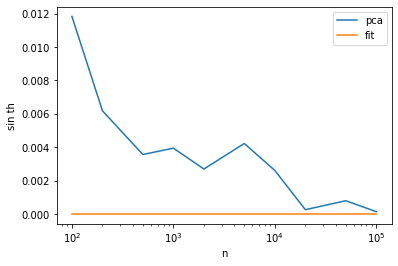

In [29]:
plot_data(pca_acc,fit_acc,y="sin th")

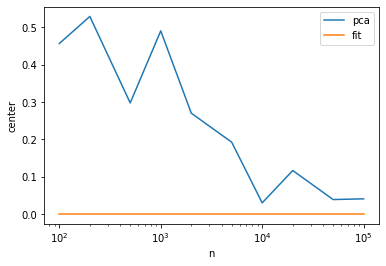

In [30]:
plot_data(pca_center,fit_center,y="center")

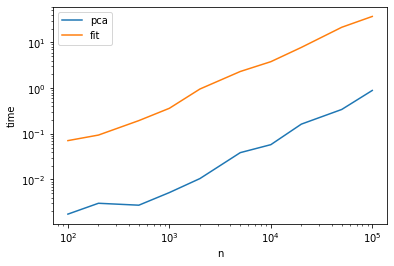

In [31]:
plot_data(pca_tm,fit_tm,y="time",log=True)

### 直径の10倍の長さの円柱，分散0.1の誤差を付加

In [32]:
r=10
l_range=[-100,100]
angle_range=[-pi,pi]

for i in range(n_x) :
    cpc=make_cylinder_point_cloud(x[i],r,l_range,angle_range,sigma=0.1,transform=tv)
    print(len(cpc))
    
    do_pca_fit()

print("finish")

100
time= 0.0011696815490722656
0.009679178834631222
fit 0 0.022044690184994106
fit 1 0.0009261670743029337
fit 2 0.0002996688355614716
fit 3 0.0002968163158404396
fit 4 0.0002968335276194433
fit 5 0.0002968334034646771
time= 0.05369877815246582
200
time= 0.001529693603515625
0.011641265359057419
fit 0 0.061846087598874305
fit 1 0.010520999966495144
fit 2 0.0003483314035029418
fit 3 0.00027089239892401677
fit 4 0.000270944749524654
fit 5 0.0002709446733407652
time= 0.08533453941345215
500
time= 0.003122091293334961
0.007402478847186788
fit 0 0.03148052320445422
fit 1 0.0005025079727529923
fit 2 5.2225770301705453e-05
fit 3 5.162698652716984e-05
fit 4 5.1627567260639644e-05
fit 5 5.1627566447253556e-05
time= 0.22875499725341797
1000
time= 0.004877567291259766
0.009607919707797358
fit 0 0.021444792613258403
fit 1 0.00085106893741678
fit 2 7.859221870511619e-05
fit 3 7.962339312177227e-05
fit 4 7.962337473303721e-05
fit 5 7.962337567978462e-05
time= 0.37218236923217773
2000
time= 0.013144

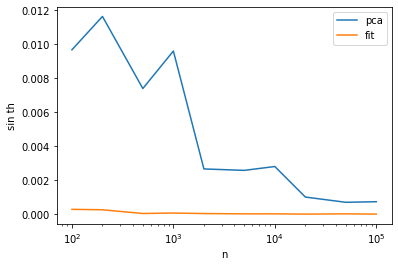

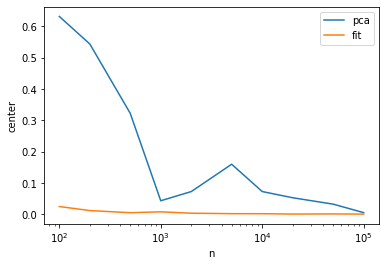

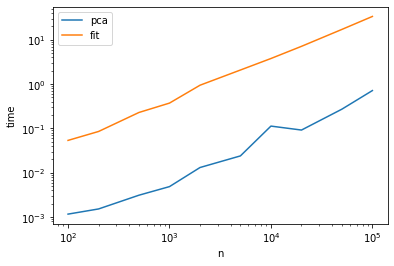

In [33]:
plot_data(pca_acc,fit_acc,y="sin th")
plot_data(pca_center,fit_center,y="center")
plot_data(pca_tm,fit_tm,y="time",log=True)

### 直径の3倍の長さの円柱．分散0.1の誤差を付加

In [34]:
r=10
l_range=[-30,30]
angle_range=[-pi,pi]

for i in range(n_x) :
    cpc=make_cylinder_point_cloud(x[i],r,l_range,angle_range,sigma=0.1,transform=tv)
    print(len(cpc))

    do_pca_fit()
    
print("finish")

100
time= 0.0011515617370605469
0.13589006488002017
fit 0 0.4032018483129849
fit 1 0.17798225928120961
fit 2 0.009634248600482991
fit 3 0.0017152023328407676
fit 4 0.0017322867171929732
fit 5 0.0017322998773046936
time= 0.05208539962768555
200
time= 0.0016410350799560547
0.017945316373912903
fit 0 0.405927212979092
fit 1 0.1397584690538864
fit 2 0.0012402475281827119
fit 3 0.00043176184967588723
fit 4 0.00043115158407868256
fit 5 0.0004311521718835907
time= 0.09092283248901367
500
time= 0.00439143180847168
0.04369023894135549
fit 0 0.41803740309719983
fit 1 0.20519383347092116
fit 2 0.0021592132158241256
fit 3 0.0010876574081009195
fit 4 0.0010875083090365883
fit 5 0.0010875073515568573
time= 0.20894145965576172
1000
time= 0.007554292678833008
0.048042219712400386
fit 0 0.41018942042326584
fit 1 0.19903561909443374
fit 2 0.0010731323454715078
fit 3 0.00025841056023444216
fit 4 0.0002587550663861721
fit 5 0.0002587552261731321
time= 0.37014079093933105
2000
time= 0.009168863296508789
0.

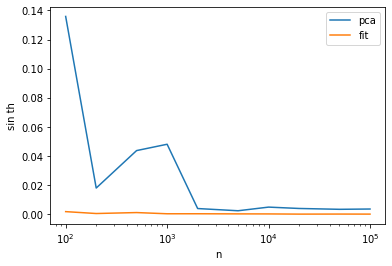

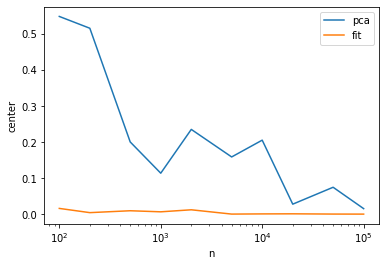

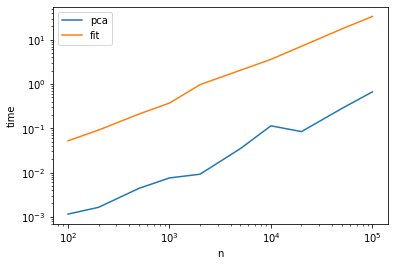

In [35]:
plot_data(pca_acc,fit_acc,y="sin th")
plot_data(pca_center,fit_center,y="center")
plot_data(pca_tm,fit_tm,y="time",log=True)

### 直径の10倍の長さの円柱．分散0.1の誤差を付加. 上部に密度の偏りを入れる

In [36]:
r=10
l_range=[-100,100]
angle_range=[-pi,pi]

for i in range(n_x) :
    cpc=make_cylinder_point_cloud(x[i],r,l_range,angle_range,sigma=0.1,transform=tv)
    cpc1=make_cylinder_point_cloud(int(x[i]/10),r,[l_range[1]/2,l_range[1]],[0,pi/2],sigma=0.1,transform=tv)
    cpc=cpc+cpc1
    print(len(cpc))
    
    do_pca_fit()

print("finish")

110
time= 0.002652406692504883
0.015636062411015277
fit 0 0.05468405841286654
fit 1 0.0021259326599056133
fit 2 0.0003265072440889298
fit 3 0.00032274281934646
fit 4 0.0003227496079552888
fit 5 0.0003227496256401879
time= 0.05822277069091797
220
time= 0.0025658607482910156
0.02175364738539068
fit 0 0.055475029462696786
fit 1 0.0019054708617332824
fit 2 7.342837782854515e-05
fit 3 7.292183873282038e-05
fit 4 7.292244036505221e-05
fit 5 7.292243988863647e-05
time= 0.10144519805908203
550
time= 0.0065267086029052734
0.01855576897494685
fit 0 0.027053857943640194
fit 1 0.00204681272751675
fit 2 0.00013202575457975192
fit 3 0.00013546301152625283
fit 4 0.00013546403045710994
fit 5 0.00013546403082773285
time= 0.21088409423828125
1100
time= 0.005664348602294922
0.016109019433223664
fit 0 0.027362302409600327
fit 1 0.0011996093734511955
fit 2 0.000171848175261297
fit 3 0.00017263837590090382
fit 4 0.00017263893356115186
fit 5 0.00017263893313963733
time= 0.40793943405151367
2200
time= 0.01103

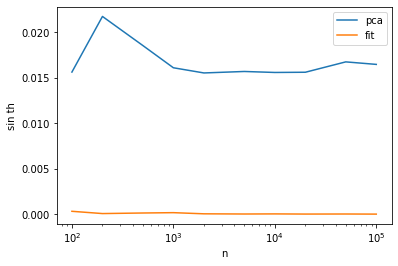

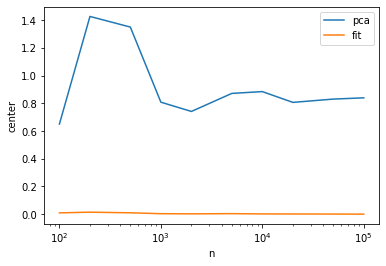

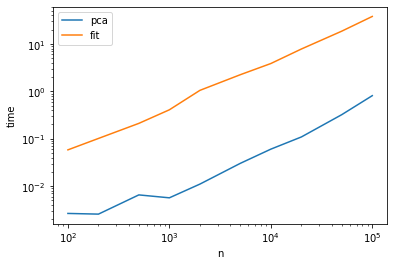

In [37]:
plot_data(pca_acc,fit_acc,y="sin th")
plot_data(pca_center,fit_center,y="center")
plot_data(pca_tm,fit_tm,y="time",log=True)

### 直径の1倍の長さの円柱．分散0.1の誤差を付加. 上部に密度の偏りを入れる

In [38]:
r=10
l_range=[-10,10]
angle_range=[-pi,pi]

for i in range(n_x) :
    cpc=make_cylinder_point_cloud(x[i],r,l_range,angle_range,sigma=0.1,transform=tv)
    cpc1=make_cylinder_point_cloud(int(x[i]/10),r,[l_range[1]/2,l_range[1]],[0,pi/2],sigma=0.1,transform=tv)
    cpc=cpc+cpc1
    print(len(cpc))
    
    do_pca_fit()

print("finish")

110
time= 0.0010590553283691406
0.9569320660906157
fit 0 0.5503623130122703
fit 1 0.14814152623121704
fit 2 0.0023255367589726547
fit 3 0.003261175610337885
fit 4 0.00325895123643025
fit 5 0.0032589591234981727
time= 0.048027753829956055
220
time= 0.001665353775024414
0.9896278339245334
fit 0 0.38093829338183294
fit 1 0.06788517952223729
fit 2 0.002242197410845431
fit 3 0.001832708764018593
fit 4 0.0018319729077520728
fit 5 0.0018319720216748547
time= 0.09569144248962402
550
time= 0.0029807090759277344
0.9371407566449815
fit 0 0.3467008450775932
fit 1 0.004684851382349711
fit 2 0.0025809950305668173
fit 3 0.00256469211012151
fit 4 0.002564726822006913
fit 5 0.0025647267178485955
time= 0.21953678131103516
1100
time= 0.00806117057800293
0.9433626460508893
fit 0 0.3982744242855714
fit 1 0.020586936954644912
fit 2 0.0004916430291111993
fit 3 0.0005414853727423022
fit 4 0.0005415155474518763
fit 5 0.0005415155598507555
time= 0.3862032890319824
2200
time= 0.010976552963256836
0.9585124414449

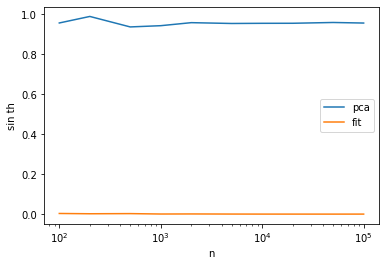

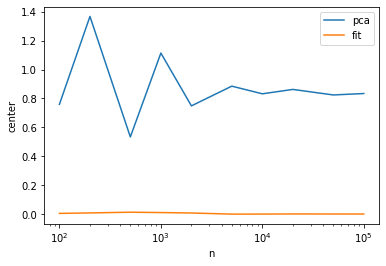

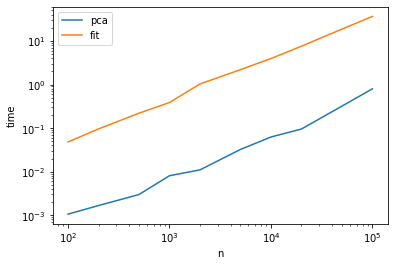

In [39]:
plot_data(pca_acc,fit_acc,y="sin th")
plot_data(pca_center,fit_center,y="center")
plot_data(pca_tm,fit_tm,y="time",log=True)

### 直径の10倍の長さの円柱，分散0.1の誤差を付加. 寸法誤差あり．

In [40]:
r=10
r_err=1.1
l_range=[-100,100]
angle_range=[-pi,pi]

for i in range(n_x) :
    cpc=make_cylinder_point_cloud(x[i],r*r_err,l_range,angle_range,sigma=0.1,transform=tv)
    print(len(cpc))
    tmp1=calc_pca(cpc)
    
    do_pca_fit()

print("finish")

100
time= 0.0010008811950683594
0.007733625701393463
fit 0 0.12259178780952934
fit 1 0.01147061976881348
fit 2 0.002848571778925374
fit 3 0.0012694025683641376
fit 4 0.0014559634893641666
fit 5 0.0014329243671867735
time= 0.0461575984954834
200
time= 0.001474142074584961
0.020998657597690856
fit 0 0.1016893270995122
fit 1 0.004840235222159196
fit 2 0.003682086320758199
fit 3 0.003811854349608048
fit 4 0.003797762496328057
fit 5 0.00379927877472264
time= 0.08003973960876465
500
time= 0.0026721954345703125
0.012626168832128248
fit 0 0.039428789561947696
fit 1 0.0032694546510328862
fit 2 0.002357411520523973
fit 3 0.0020833562583793207
fit 4 0.002108972638755824
fit 5 0.0021063586221161503
time= 0.19849491119384766
1000
time= 0.004193544387817383
0.0038038503189395476
fit 0 0.028078083197331336
fit 1 0.0027678603369788815
fit 2 0.0005098650340405763
fit 3 0.0005737305517788287
fit 4 0.000563789784072521
fit 5 0.0005646566795976412
time= 0.3891012668609619
2000
time= 0.011465311050415039
0

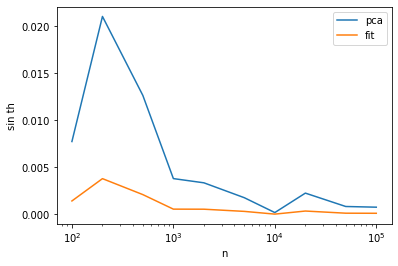

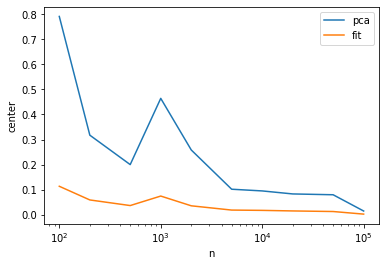

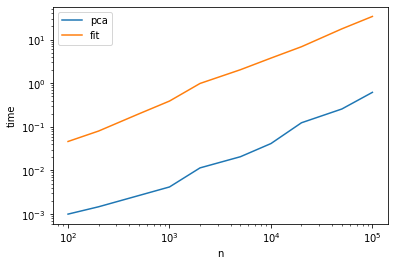

In [41]:
plot_data(pca_acc,fit_acc,y="sin th")
plot_data(pca_center,fit_center,y="center")
plot_data(pca_tm,fit_tm,y="time",log=True)